In [1]:
# 1.- Import libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from skmultiflow.data.stagger_generator import STAGGERGenerator

In [2]:
# 2.- Disable warnings because they appera at training with BernoulliNB
warnings.filterwarnings("ignore")

In [3]:
# 3.- Stagger generator, it takes the size of the sample and generate a series with drift
#     The StaggerGenerator from skmultiflow was used

def generator(steps, examples, t):
    
    # 3.1 Initialization
    a = int(steps/3)
    b = int(steps*2/3)
    
    dataset = np.zeros((examples,9))
    labels = np.zeros((examples))
    
    stream0 = STAGGERGenerator(classification_function = 0, balance_classes = False)
    stream1 = STAGGERGenerator(classification_function = 1, balance_classes = False)
    stream2 = STAGGERGenerator(classification_function = 2, balance_classes = False)
    stream0.prepare_for_use()
    stream1.prepare_for_use()
    stream2.prepare_for_use()
    
    temp = np.zeros((examples,4), dtype=str)
    
    # 3.2.- Sample generation
    
    for i in range(examples):
        if (t < int(steps/3)):
            sample = stream0.next_sample()
            temp[i,0:3] = sample[0][0]
            temp[i, 3] = sample[1][0]
        elif (t >= int(steps/3) and t < int(2 *steps/3)):
            sample = stream1.next_sample()
            temp[i,0:3] = sample[0][0]
            temp[i, 3] = sample[1][0]           
        elif (t >= int(2 *steps/3)):
            sample = stream2.next_sample()
            temp[i,0:3] = sample[0][0]
            temp[i, 3] = sample[1][0]            
    
    # 3.3.- One hot encoding
    df = pd.DataFrame(temp, columns = ['Size', 'Shape', 'Color', 'Output']) 
    mask = df.dtypes==object
    cols = df.columns[mask].tolist()
    label_encoder = preprocessing.LabelEncoder()
    onehot_encoder = preprocessing.OneHotEncoder(categorical_features = mask, sparse=False)
    df[cols] = df[cols].apply(lambda col: label_encoder.fit_transform(col))
    features_ohe = onehot_encoder.fit_transform(df)

    dataset[:, :] = features_ohe[:, 0:9]
    labels[:] = features_ohe[:, 9]

    return dataset, labels

In [20]:
# 4.- Main function for executing the algorithm

def main(steps, n):
    
    #4.1.- Initialization
    
    beta = 0.5
    theta = 0.01
    p = 1
    
    e = [BernoulliNB()]
    w = [1] 
    m = 1
    perf = BernoulliNB()
    NB = BernoulliNB()
    
    l_h = []
    acc_h = []
    p_acc_h = []
    NB_acc_h = []

    perf.partial_fit(np.random.choice(2, (1,9)), np.array([0]), [0, 1])
    NB.partial_fit(np.random.choice(2, (1,9)), np.array([0]), [0, 1])
    e[0].partial_fit(np.random.choice(2, (1,9)), np.array([0]), [0, 1])

    # 4.2.- Algorithm 
    for t in range(0,steps):
        # 4.2.1.- Generate train and test data
        
        data, labels = generator(steps, n, t)
        X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = (n-1)/n, random_state=42)
        sigma = np.zeros((2,1))
        
        # 4.2.2.- Evaluation and weight update
        for j in range(0,m):
            local_pred = e[j].predict(X_train)

            if (local_pred != Y_train):
                w[j] = beta * w[j]
            sigma[local_pred] = sigma[local_pred] + w[j]

        # 4.2.3.- Test evaluation for performance
        glob_pred = np.argmax(sigma)
        pred = np.zeros((X_test.shape[0], 2))

        for j, model in enumerate(e):
            Y_pred = model.predict(X_test)
            for k in range(X_test.shape[0]):
                pred[k, Y_pred[k]] = pred[k, Y_pred[k]] + w[j]

        global_prediction = np.argmax(pred, axis=1)
        acc_h.append(accuracy_score(Y_test, global_prediction))

        norm_pred = NB.predict(X_test)
        NB_acc_h.append(accuracy_score(Y_test, norm_pred))

        perf_pred = perf.predict(X_test)
        p_acc_h.append(accuracy_score(Y_test, perf_pred))

        # 4.2.4.- Update the forgotten classifier
        if(t==int(steps/3) or t==int(2*steps/3)):
            perf = BernoulliNB()

        # 4.2.5.- Classifiers update
        if (t % p == 0):
            w[:] = w[:]/np.max(w)
            for i, j in enumerate(e):
                if (w[i] < theta and m > 1):
                    e.pop(i)
                    w.pop(i)
                    m -= 1
            if (glob_pred != Y_train):
                m += 1
                e.append(BernoulliNB())
                w.append(1)
        
        # 4.2.6.- Saving for logging purposes
        l_h.append(m)
        
        # 4.2.7.- Train on the new element
        for j, model in enumerate(e):
            model.partial_fit(X_train, Y_train, [0, 1])

        perf.partial_fit(X_train, Y_train, [0, 1])
        NB.partial_fit(X_train, Y_train, [0, 1])

        
    # 4.3.- Plot the results
    plt.plot(range(0,steps), acc_h, label='DWM', color='green')
    plt.plot(range(0,steps), p_acc_h, label='Forgetting', color='orange')
    plt.plot(range(0,steps), NB_acc_h, label='Naive Bayes', color='red')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Time')
    plt.ylabel('Acc')
    plt.show()

    plt.plot(range(steps), l_h, label='DWM', color='pink')
    plt.legend()
    plt.title('Nº of learners')
    plt.xlabel('Time')
    plt.ylabel('Learners')
    plt.show()

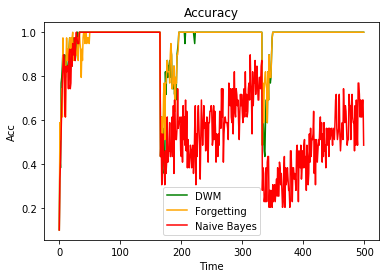

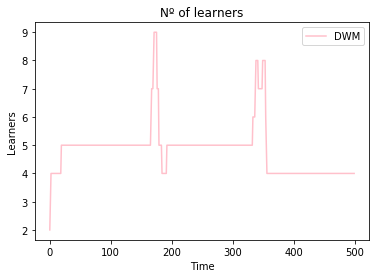

In [21]:
main(500,40)

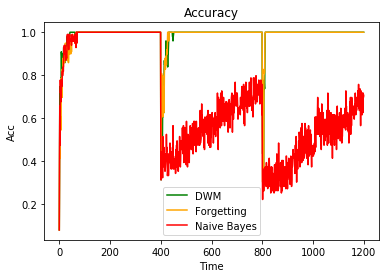

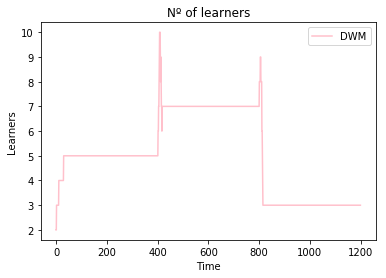

In [22]:
main(1200, 100)

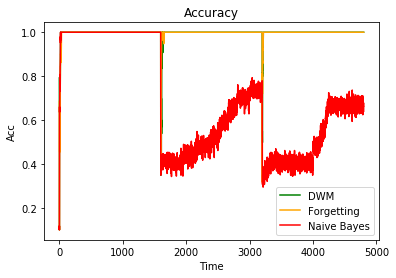

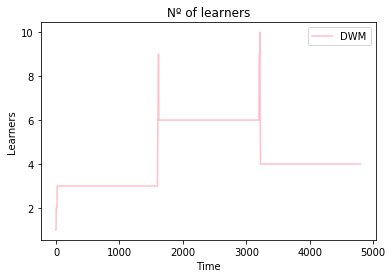

In [23]:
main(4800, 500)

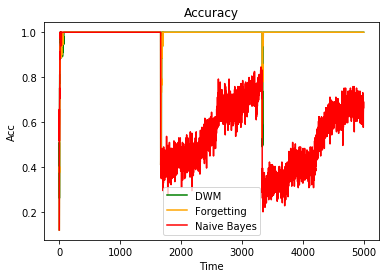

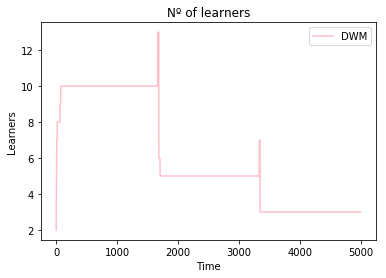

In [24]:
main(5000, 150)

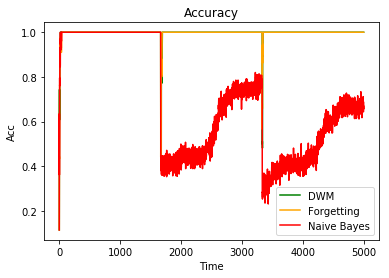

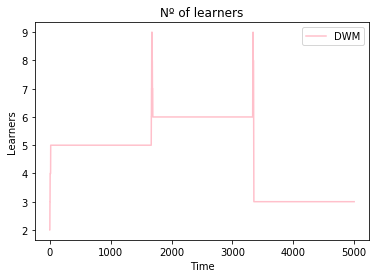

In [25]:
main(5000, 500)

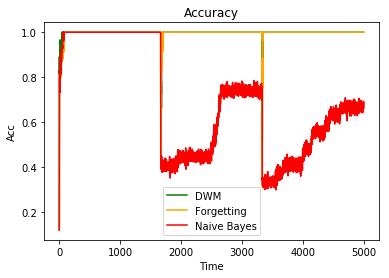

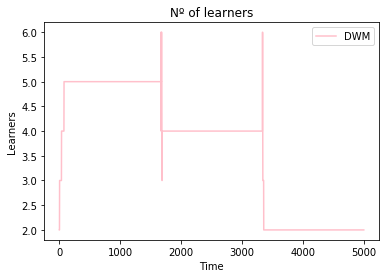

In [26]:
main(5000, 1000)